In [21]:
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import math
import logging
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score
from collections import Counter
import os
import csv
import xgboost as xgb
import logging
from sklearn import preprocessing, linear_model
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')
logging.getLogger().setLevel(logging.INFO)

In [22]:
config_path = "/Users/haoran/Documents/BUAA_course/matchine_learnign/final_work/personal_work/predict_price/" \
              "config/config.json"
config = json.load(open(config_path))
raw_data = pd.read_csv(config['raw_data_path'])

In [23]:
print("原始数据特征数量：", raw_data.columns.shape)

原始数据特征数量： (81,)


In [24]:
# 查看所有特征的数据量情况
print(raw_data.info())
# 数据量少于1160的特征均存在缺失
# 其中，Alley，FireplaceQu，PoolQC，Fence，MiscFeature缺失严重，需要丢弃

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160 entries, 0 to 1159
Data columns (total 81 columns):
Id               1160 non-null int64
MSSubClass       1160 non-null int64
MSZoning         1160 non-null object
LotFrontage      955 non-null float64
LotArea          1160 non-null int64
Street           1160 non-null object
Alley            67 non-null object
LotShape         1160 non-null object
LandContour      1160 non-null object
Utilities        1160 non-null object
LotConfig        1160 non-null object
LandSlope        1160 non-null object
Neighborhood     1160 non-null object
Condition1       1160 non-null object
Condition2       1160 non-null object
BldgType         1160 non-null object
HouseStyle       1160 non-null object
OverallQual      1160 non-null int64
OverallCond      1160 non-null int64
YearBuilt        1160 non-null int64
YearRemodAdd     1160 non-null int64
RoofStyle        1160 non-null object
RoofMatl         1160 non-null object
Exterior1st      1160 non-nu

In [25]:
def delet_nan(raw_data):
    """
    将数据中空值太多的特征去掉
    :param raw_data:
    :return:
    """
    data = raw_data.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu', "Electrical"], axis=1, inplace=False)
    return data

In [26]:
def find_anomaly(column, threshold):
    """
    从column中找出大于threshold的元素，并返回索引
    """
    index = np.where(column > threshold)
    return pd.DataFrame(np.array(index))
ii = find_anomaly(raw_data["TotalBsmtSF"], 6000)
print(ii)

      0
0  1039


In [27]:
def MAPE(true, pred):
    """
    计算相对百分比误差
    :param data:
    :return:
    """
    diff = np.abs(np.array(true) - np.array(pred))
    return np.mean(diff / true)

In [28]:
def convert_onehot(data, name):
    """
    将非数值特征做one hot编码
    :param data:原始数据矩阵
    :return:
    """
    out = LabelBinarizer().fit_transform(data[name])
    return np.array(out)

In [29]:
def conver_onehot_test(train, test, name):
    lab = LabelBinarizer()
    train_out = lab.fit_transform(train[name])
    test_out = lab.transform(test[name])
    return np.array(test_out)

In [30]:
def is_nan(column):
    """
    判断一列特征是否存在缺失值
    :param column:
    :return:存在缺失，返回True，不存在缺失，返回False
    """
    column = np.array(column)
    column = pd.DataFrame(column)
    print("是否存在缺失值(True-存在；False-不存在)")
    print(column.isnull().any())

In [31]:
def fill_nan_scalar(column):
    """
    用前一个和后一个数的均值来填补NAN
    :param column:
    :return:
    """
    index = np.where(np.isnan(column))
    index = np.array(index).reshape(-1)
    for i in range(index.shape[0]):
        column[index[i]] = np.nanmean([column[index[i]-1], column[index[i]+1]])

In [32]:
def fill_nan_label(column):
    """
    将缺失的部分看做新的类别，用AA填充
    :param column:
    :return:
    """
    column = column.fillna(value="AA")
    return column

In [33]:
def build_model():
#     model = RandomForestRegressor(n_estimators=1000, random_state=0, n_jobs=-1)
#     model = GradientBoostingRegressor(loss='ls',
#                                       learning_rate=0.1,
#                                       n_estimators=100,
#                                       subsample=1,
#                                       min_samples_split=2,
#                                       min_samples_leaf=1,
#                                       max_depth=3,
#                                       init=None,
#                                       random_state=None,
#                                       max_features=None,
#                                       alpha=0.9,
#                                       verbose=0,
#                                       max_leaf_nodes=None,
#                                       warm_start=False)
    model = GradientBoostingRegressor()
    return model

In [34]:
# 数据清洗 - 填补缺失值

In [35]:
# 将Alley，FireplaceQu，PoolQC，Fence，MiscFeature五个特征去掉
raw_data = delet_nan(raw_data)
# print("去掉缺失值太多的特征之后的剩余特征数量：", raw_data.columns.shape)

In [36]:
# 将有缺失值的三个数值类字段fill
fill_nan_scalar(raw_data["LotFrontage"])
fill_nan_scalar(raw_data["MasVnrArea"])
fill_nan_scalar(raw_data["GarageYrBlt"])

In [37]:
# 类别特征的缺失值用“AA”填充，作为新的类别
raw_data["MasVnrType"] = fill_nan_label(raw_data["MasVnrType"])
raw_data["BsmtQual"] = fill_nan_label(raw_data["BsmtQual"])
raw_data["BsmtCond"] = fill_nan_label(raw_data["BsmtCond"])
raw_data["BsmtExposure"] = fill_nan_label(raw_data["BsmtExposure"])
raw_data["BsmtFinType1"] = fill_nan_label(raw_data["BsmtFinType1"])
raw_data["BsmtFinType2"] = fill_nan_label(raw_data["BsmtFinType2"])
# raw_data["Electrical"] = fill_nan_label(raw_data["Electrical"])
raw_data["GarageType"] = fill_nan_label(raw_data["GarageType"])
raw_data["GarageFinish"] = fill_nan_label(raw_data["GarageFinish"])
raw_data["GarageQual"] = fill_nan_label(raw_data["GarageQual"])
raw_data["GarageCond"] = fill_nan_label(raw_data["GarageCond"])

In [38]:
# 再看一下数据是否还有缺失
print(raw_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160 entries, 0 to 1159
Data columns (total 75 columns):
Id               1160 non-null int64
MSSubClass       1160 non-null int64
MSZoning         1160 non-null object
LotFrontage      1160 non-null float64
LotArea          1160 non-null int64
Street           1160 non-null object
LotShape         1160 non-null object
LandContour      1160 non-null object
Utilities        1160 non-null object
LotConfig        1160 non-null object
LandSlope        1160 non-null object
Neighborhood     1160 non-null object
Condition1       1160 non-null object
Condition2       1160 non-null object
BldgType         1160 non-null object
HouseStyle       1160 non-null object
OverallQual      1160 non-null int64
OverallCond      1160 non-null int64
YearBuilt        1160 non-null int64
YearRemodAdd     1160 non-null int64
RoofStyle        1160 non-null object
RoofMatl         1160 non-null object
Exterior1st      1160 non-null object
Exterior2nd      1160 non

In [39]:
# 没有缺失了

In [40]:
# 数据清理 - 异常值与相关性分析

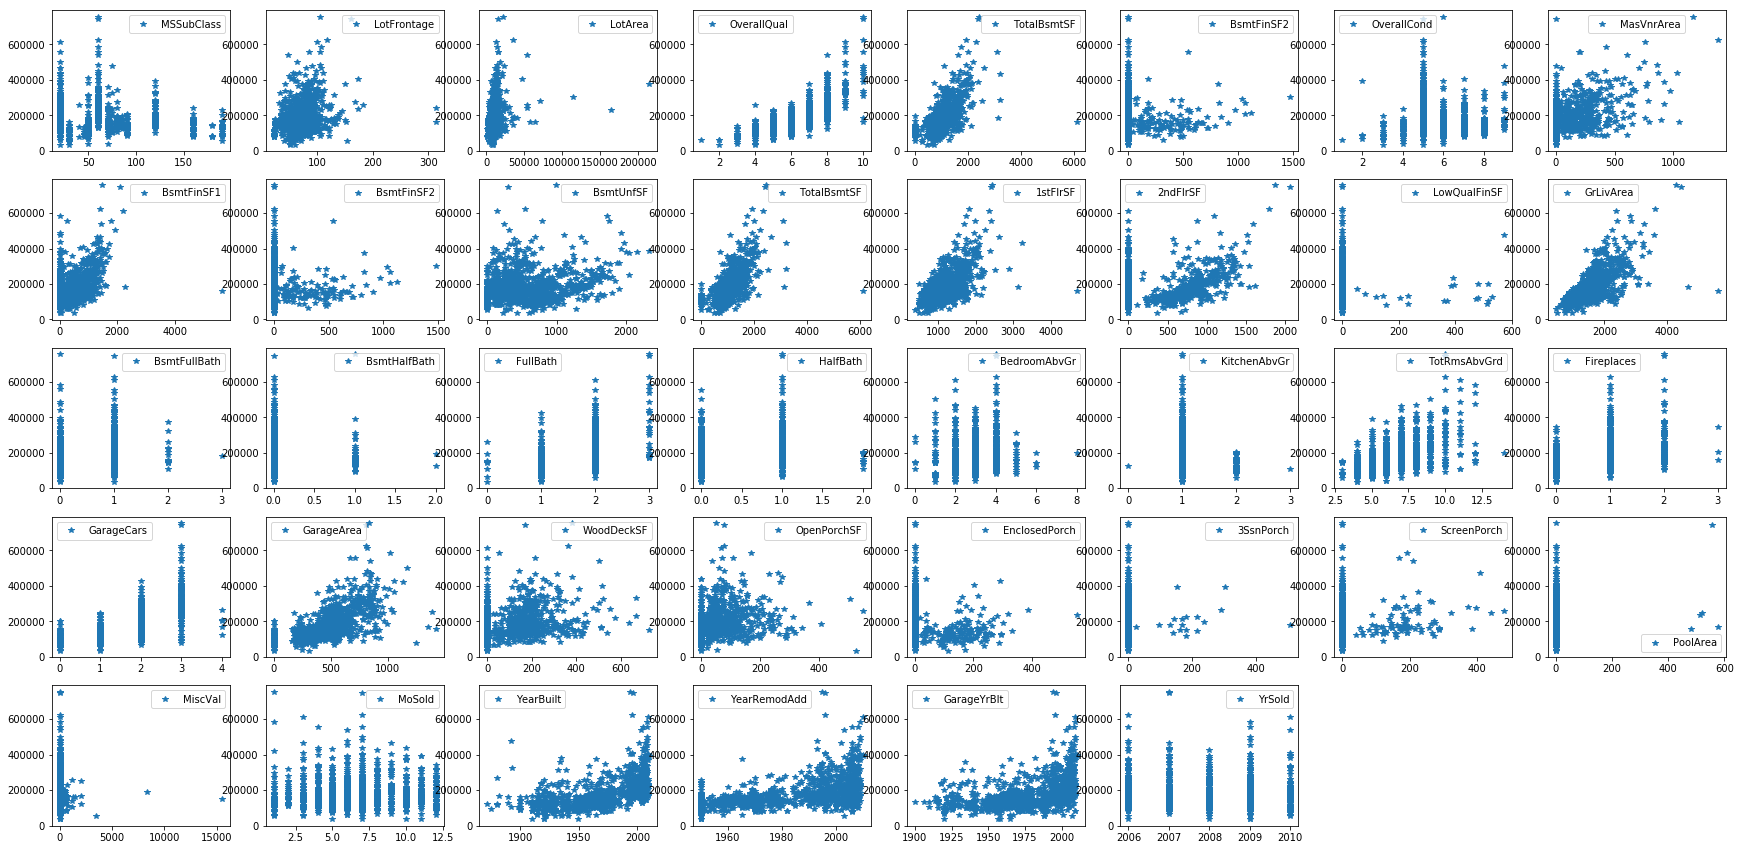

In [41]:
# 所有数值特征和房价的散点图
scalar_name = ["MSSubClass", "LotFrontage", "LotArea", "OverallQual", "TotalBsmtSF", "BsmtFinSF2", 
        "OverallCond", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", 
        "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea", "BsmtFullBath", "BsmtHalfBath", 
        "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces",
       "GarageCars", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", 
        "ScreenPorch", "PoolArea", "MiscVal", "MoSold", "YearBuilt", "YearRemodAdd", "GarageYrBlt", "YrSold"]
nn = 0
plt.figure(figsize=(30, 15))
for i in scalar_name:
    nn = nn + 1
    plt.subplot(5,8, nn)
    plt.plot(raw_data[i], raw_data["SalePrice"], '*', label=i)
    plt.legend()
plt.savefig("/Users/haoran/Documents/BUAA_course/matchine_learnign/final_work/personal_work/predict_price/sandiantu.png")
plt.show()

In [42]:
# 从散点图可以得出的结论：
# 1.年份特征YearBuilt，YearRemodAdd，GarageYrBlt与房价的相关性很高
# 2.可以发现个别异常值，先不考虑去除异常值，看看会不会影响模型精度

feature importances ----------------------- 
 1) OverallQual                    0.579393
 2) GrLivArea                      0.095921
 3) 2ndFlrSF                       0.041904
 4) BsmtFinSF1                     0.036139
 5) 1stFlrSF                       0.034132
 6) GarageCars                     0.023742
 7) TotalBsmtSF                    0.020457
 8) TotalBsmtSF                    0.019099
 9) GarageArea                     0.017710
10) LotArea                        0.016984
11) YearBuilt                      0.016402
12) YearRemodAdd                   0.009783
13) FullBath                       0.009728
14) TotRmsAbvGrd                   0.008990
15) LotFrontage                    0.008359
16) BsmtUnfSF                      0.007363
17) MasVnrArea                     0.007048
18) OpenPorchSF                    0.006501
19) GarageYrBlt                    0.006140
20) OverallCond                    0.005867
21) WoodDeckSF                     0.004988
22) MoSold                     

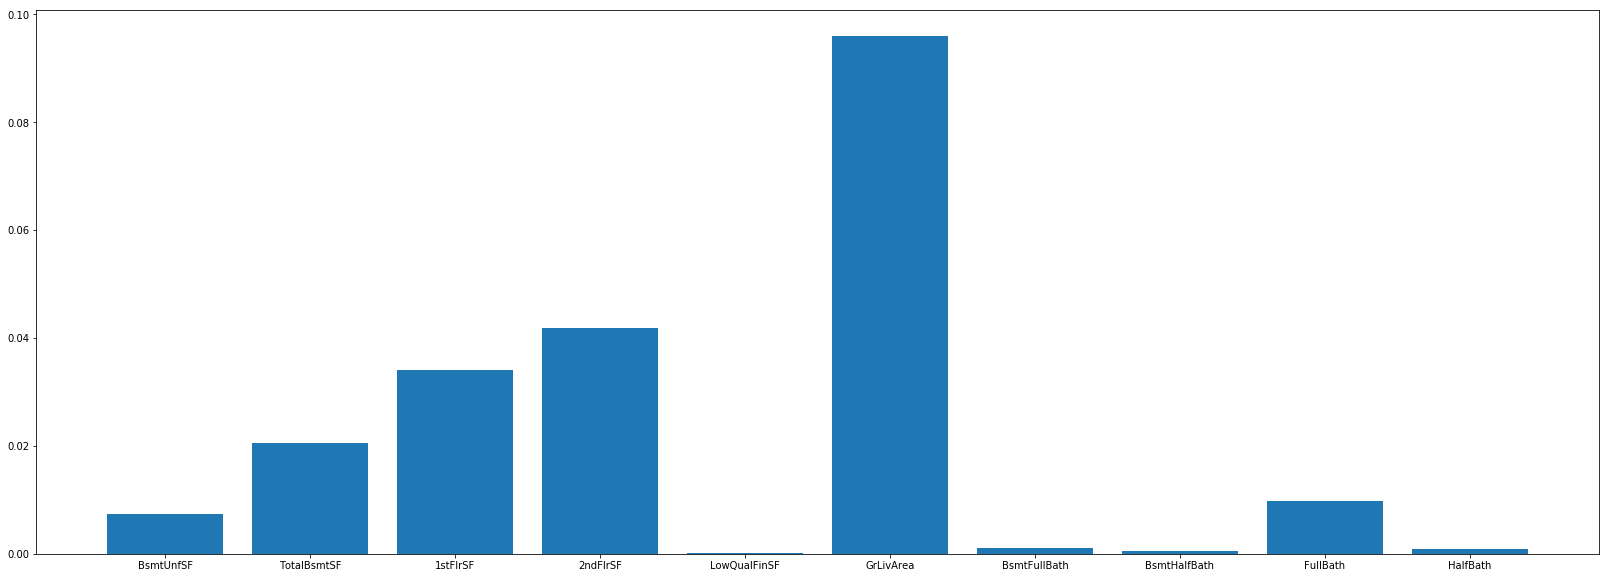

In [43]:
# 数值特征对房价的重要度分析 - 随机森林
forest = RandomForestRegressor(n_estimators=1000, random_state=0, n_jobs=-1)
forest.fit(raw_data[scalar_name], raw_data["SalePrice"])
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
print("feature importances ----------------------- ")
for f in range(raw_data[scalar_name].shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, scalar_name[indices[f]], importances[indices[f]]))
plt.figure(figsize=(28, 10))
plt.bar(range(len(importances[10:20])), importances[10:20], tick_label=scalar_name[10:20])
plt.savefig("/Users/haoran/Documents/BUAA_course/matchine_learnign/final_work/personal_work/predict_price/zhu10-20.png")
plt.show()

In [44]:
# 将类别特征one hot编码
label_name = ["MSZoning", "Street", "LotShape", "LandContour", "Utilities", "LotConfig", "LandSlope", 
              "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", 
              "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "ExterQual", "ExterCond", 
              "Foundation", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", 
              "Heating", "HeatingQC", "CentralAir", "KitchenQual", "Functional", 
              "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PavedDrive", "SaleType", 
              "SaleCondition"]
# print(raw_data[label_name].info())
label_column = pd.DataFrame(convert_onehot(raw_data, label_name[0]))
for i in label_name:
    if i != "MSZoning":
        temp = convert_onehot(raw_data, i)
        label_column = pd.concat([pd.DataFrame(label_column), pd.DataFrame(temp)], axis=1)
label_column = np.array(label_column)
print(label_column[0:15])
print(label_column.shape)

[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]]
(1160, 234)


In [45]:
# 将处理好的数值特征和类别特征合并在一起，增加一步：将数值特征做归一化
min_max_scalar1 = preprocessing.MinMaxScaler()
final_data = pd.concat([pd.DataFrame(raw_data[scalar_name]), pd.DataFrame(label_column)], axis=1)
final_data = np.array(final_data)
print(final_data.shape)

(1160, 272)


In [46]:
# 划分数据集
target = raw_data["SalePrice"]
x_train, x_test, y_train, y_test = train_test_split(final_data, target, test_size = 0.2, random_state = 0)

In [47]:
# 将处理好的数据保存到本地
def write_2_local(data, path):
    w = pd.DataFrame(data)
    w.to_csv(path, index=None, header=None)
    print("file have written to", path)
write_2_local(x_train, "/Users/haoran/Documents/BUAA_course/matchine_learnign/final_work/personal_work/houseprice_data/x_train.csv")
write_2_local(x_test, "/Users/haoran/Documents/BUAA_course/matchine_learnign/final_work/personal_work/houseprice_data/x_test.csv")
write_2_local(y_train, "/Users/haoran/Documents/BUAA_course/matchine_learnign/final_work/personal_work/houseprice_data/y_train.csv")
write_2_local(y_test, "/Users/haoran/Documents/BUAA_course/matchine_learnign/final_work/personal_work/houseprice_data/y_test.csv")

file have written to /Users/haoran/Documents/BUAA_course/matchine_learnign/final_work/personal_work/houseprice_data/x_train.csv
file have written to /Users/haoran/Documents/BUAA_course/matchine_learnign/final_work/personal_work/houseprice_data/x_test.csv
file have written to /Users/haoran/Documents/BUAA_course/matchine_learnign/final_work/personal_work/houseprice_data/y_train.csv
file have written to /Users/haoran/Documents/BUAA_course/matchine_learnign/final_work/personal_work/houseprice_data/y_test.csv


In [48]:
# 搭建baseline
# 模型：随机森林
target = raw_data["SalePrice"]
model = build_model()
# model = xgb.XGBRegressor()
model.fit(x_train, y_train)
pre = model.predict(x_test)

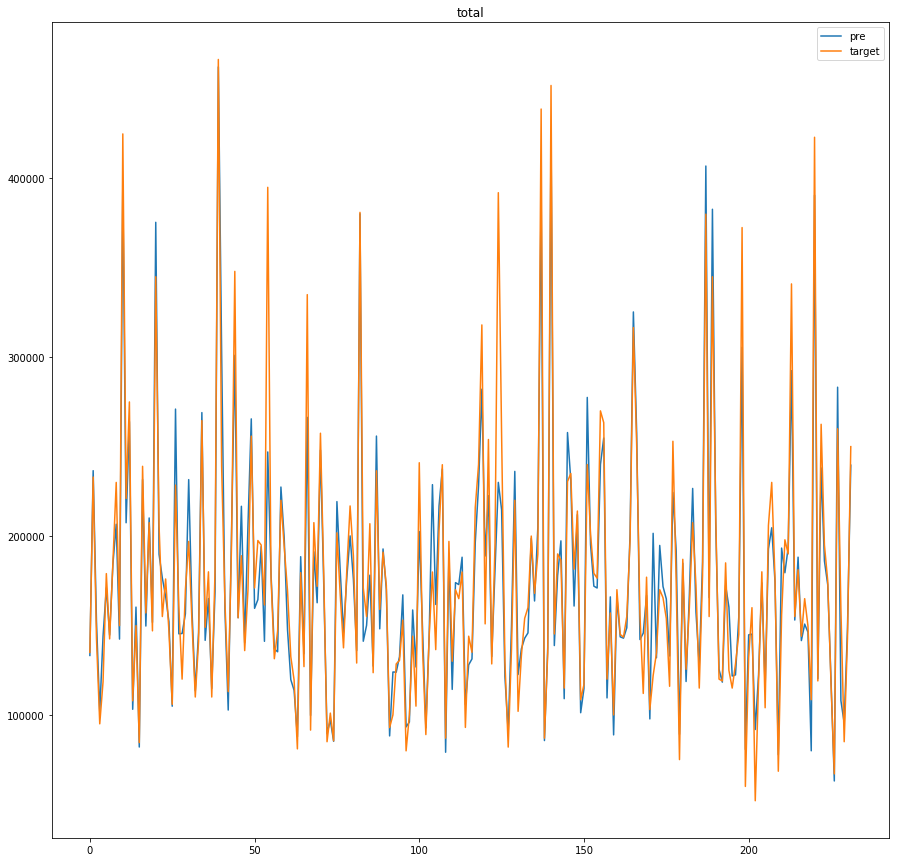

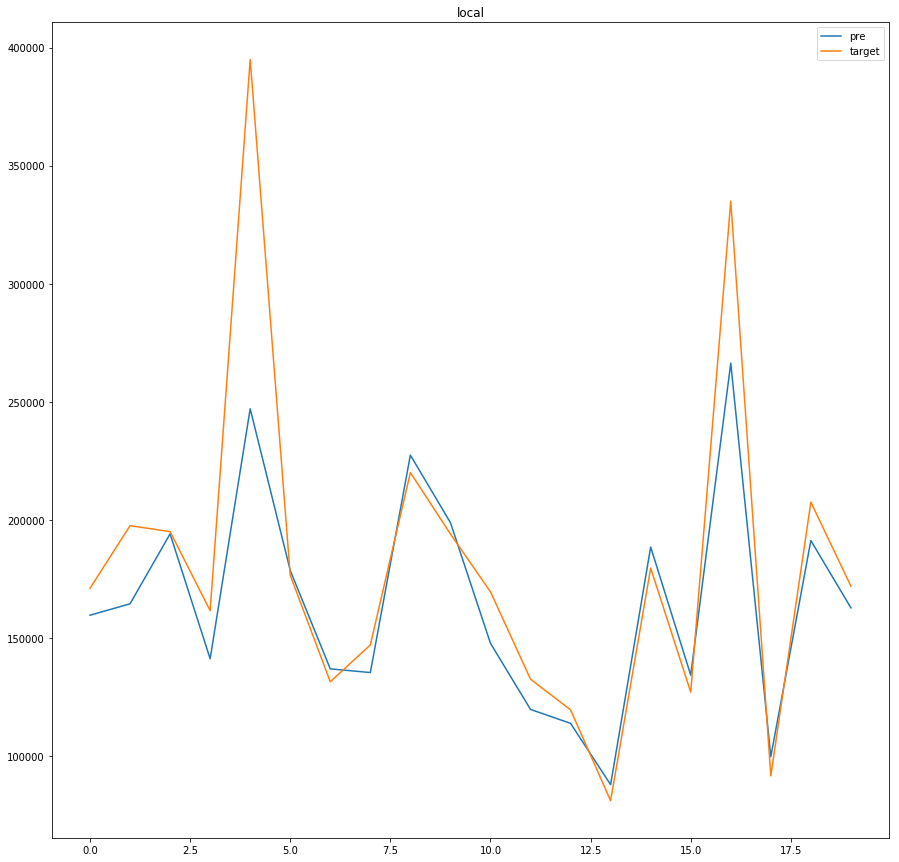

INFO:root:mse=574809759.498691
INFO:root:rmse=23975.190499737244
INFO:root:mape=0.08520855354824462
INFO:root:r2=0.876674804397549


In [49]:
plt.figure(figsize=(15, 15))
plt.title("total")
plt.plot(np.array(pre), label="pre")
plt.plot(np.array(y_test), label="target")
plt.legend()
plt.savefig('/Users/haoran/Documents/BUAA_course/matchine_learnign/final_work/personal_work/predict_price/figure/baseline_total_prediction.png')
plt.show()
mse = metrics.mean_squared_error(np.array(y_test), np.array(pre))
rmse = np.sqrt(mse)
mape = MAPE(np.array(y_test), np.array(pre))
r2 = r2_score(np.array(pre), np.array(y_test))
plt.figure(figsize=(15, 15))
plt.title("local")
plt.plot(np.array(pre)[50:70], label="pre")
plt.plot(np.array(y_test)[50:70], label="target")
plt.legend()
plt.savefig('/Users/haoran/Documents/BUAA_course/matchine_learnign/final_work/personal_work/predict_price/figure/baseline_local_prediction.png')
plt.show()
logging.info('mse={}'.format(mse))
logging.info('rmse={}'.format(rmse))
logging.info('mape={}'.format(mape))
logging.info('r2={}'.format(r2))

In [209]:
# 测试
test_data = pd.read_csv(config['test_data_path'])

In [210]:
# 看看测试集的数据情况
# print(test_data.info())

In [211]:
# 测试集的缺失情况居然和训练集不一样

In [ ]:
# 去掉训练集中缺失严重的5个特征，然后看一下数据情况
test_data = delet_nan(test_data)
# print(test_data.info())

In [142]:
# 填补数值变量NAN
fill_nan_scalar(test_data["LotFrontage"])
fill_nan_scalar(test_data["MasVnrArea"])
fill_nan_scalar(test_data["GarageYrBlt"])

In [143]:
# 看一下填补数值特征NAN之后的数据情况
# print(test_data.info())

In [144]:
# 类别特征的缺失值用“AA”填充，作为新的类别
test_data["MasVnrType"] = fill_nan_label(test_data["MasVnrType"])
test_data["BsmtQual"] = fill_nan_label(test_data["BsmtQual"])
test_data["BsmtCond"] = fill_nan_label(test_data["BsmtCond"])
test_data["BsmtExposure"] = fill_nan_label(test_data["BsmtExposure"])
test_data["BsmtFinType1"] = fill_nan_label(test_data["BsmtFinType1"])
test_data["BsmtFinType2"] = fill_nan_label(test_data["BsmtFinType2"])
test_data["GarageType"] = fill_nan_label(test_data["GarageType"])
test_data["GarageFinish"] = fill_nan_label(test_data["GarageFinish"])
test_data["GarageQual"] = fill_nan_label(test_data["GarageQual"])
test_data["GarageCond"] = fill_nan_label(test_data["GarageCond"])

In [101]:
# 再看一下数据情况
# print(test_data.info())

In [102]:
# 将类别特征one hot编码
label_column_test = pd.DataFrame(conver_onehot_test(raw_data, test_data, label_name[0]))
for i in label_name:
    if i != "MSZoning":
        temp1 = conver_onehot_test(raw_data, test_data, i)
        label_column_test = pd.concat([pd.DataFrame(label_column_test), pd.DataFrame(temp1)], axis=1)
label_column_test = np.array(label_column_test)
print(label_column_test.shape)

(300, 234)


In [103]:
# 将数值特征和类别特征合并在一起，增加对数值特征进行归一化
final_test_data = pd.concat([pd.DataFrame(test_data[scalar_name]), pd.DataFrame(label_column_test)], axis=1)
final_test_data = np.array(final_test_data)
print(final_test_data.shape)

(300, 272)


In [104]:
# 将处理好的测试数据写到本地
write_2_local(final_test_data, "/Users/haoran/Documents/BUAA_course/matchine_learnign/final_work/personal_work/houseprice_data/final_tes_data.csv")

file have written to /Users/haoran/Documents/BUAA_course/matchine_learnign/final_work/personal_work/houseprice_data/final_tes_data.csv


In [105]:
# 统计训练集和测试集中每个类别特征中有多少不同的值
# 如果特征在训练集和测试集中的不同值得个数相同，则没问题；否则，有问题
# for ii in label_name:
#     print(ii)
#     print("train:",len(np.unique(raw_data[ii])))
#     print("test:", len(np.unique(test_data[ii])))

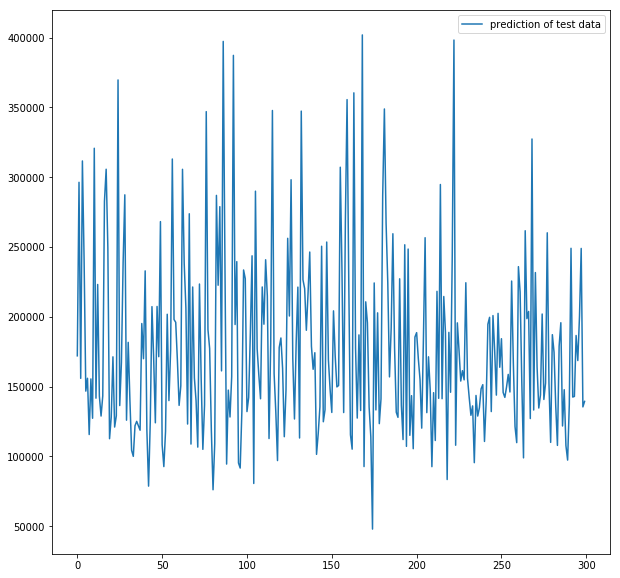

In [106]:
# 用训练好的模型预测
prediction = model.predict(final_test_data)
prediction = np.array(prediction)
plt.figure(figsize=(10,10))
plt.plot(prediction, label="prediction of test data")
plt.legend()
plt.savefig('/Users/haoran/Documents/BUAA_course/matchine_learnign/final_work/personal_work/predict_price/figure/result_gbdt.png')
plt.show()

In [107]:
# 将测试集结果保存到本地
id = test_data["Id"]
out = pd.concat([pd.DataFrame(id), pd.DataFrame(prediction, columns=["SalePrice"])], axis=1)
# print(out)

In [108]:
wd = pd.DataFrame(out)
wd.to_csv(config["result_save_path"], index=None)
print("saved to:", config["result_save_path"])

saved to: /Users/haoran/Documents/BUAA_course/matchine_learnign/final_work/personal_work/houseprice_data/result_gbdt.csv
